# Classification

<div class="btn btn-notebook" role="button">
    <img src="../_static/images/colab_logo_32px.png"> [Run in Google Colab](https://colab.research.google.com/drive/1ANQUix9Y6V4RXu-vAaCFGmU979d5m4bO?usp=sharing)
</div>
<div class="btn btn-notebook" role="button">
    <img src="../_static/images/github_logo_32px.png"> [View on GitHub](https://github.com/adapt-python/adapt/blob/master/docs/examples/Classification.ipynb)
</div>

You will find here the application of DA methods from the ADAPT package on a simple two 
dimensional DA classification problem.

First we import packages needed in the following. We will use ``matplotlib Animation`` tools in order to
get a visual understanding of the mselected methods:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from sklearn.metrics import accuracy_score

## Experimental Setup

We now set the synthetic classification DA problem using the [make_classification_da](../generated/adapt.utils.make_classification_da.html) function from ``adapt.utils``.

In [2]:
from adapt.utils import make_classification_da

Xs, ys, Xt, yt = make_classification_da()

x_grid, y_grid = np.meshgrid(np.linspace(-0.1, 1.1, 100),
                             np.linspace(-0.1, 1.1, 100))
X_grid = np.stack([x_grid.ravel(), y_grid.ravel()], -1)

We define here ``show`` function which we will use in the following to visualize the algorithms performances
on the toy problem.

In [3]:
def show(yp_grid=None, yp_t=None, x_grid=x_grid, y_grid=y_grid, Xs=Xs, Xt=Xt,
         weights_src=50*np.ones(100), disc_grid=None):
    cm = matplotlib.colors.ListedColormap(['w', 'r', 'w'])
    ax = plt.gca()
    if yp_grid is not None:
        ax.contourf(x_grid, y_grid, yp_grid, cmap=cm, alpha=1.)
        ax.plot([Xs[0, 0]], [Xs[0, 1]], c="red", label="class separation")
    if disc_grid is not None:
        cm_disc = matplotlib.colors.ListedColormap([(1,1,1,0), 'g', (1,1,1,0)])
        ax.contourf(x_grid, y_grid, disc_grid, cmap=cm_disc, alpha=0.5)
        ax.plot([Xs[0, 0]], [Xs[0, 1]], c="green", label="disc separation")
    if yp_t is not None:
        score = accuracy_score(yt.ravel(), yp_t.ravel())
        score = " -- Tgt Acc = %.2f"%score
    else:
        score = ""
    ax.scatter(Xs[ys==0, 0], Xs[ys==0, 1], label="source", edgecolors='k',
               c="C0", s=weights_src[ys==0], marker="o", alpha=0.9)
    ax.scatter(Xs[ys==1, 0], Xs[ys==1, 1], edgecolors='k',
               c="C0", s=2*weights_src[ys==1], marker="*", alpha=0.9)
    ax.scatter(Xt[yt==0, 0], Xt[yt==0, 1], label="target", edgecolors='k',
               c="C1", s=50, marker="o", alpha=0.9)
    ax.scatter(Xt[yt==1, 0], Xt[yt==1, 1], edgecolors='k',
               c="C1", s=100, marker="*", alpha=0.9)
    ax.legend(fontsize=14, loc="upper left")
    ax.set_xlabel("X0", fontsize=16)
    ax.set_ylabel("X1", fontsize=16)
    plt.suptitle("Toy classification DA issue"+score, fontsize=18)
    
Writer = animation.writers['ffmpeg']
writer = Writer(fps=20, metadata=dict(artist='Adapt'), bitrate=1800)

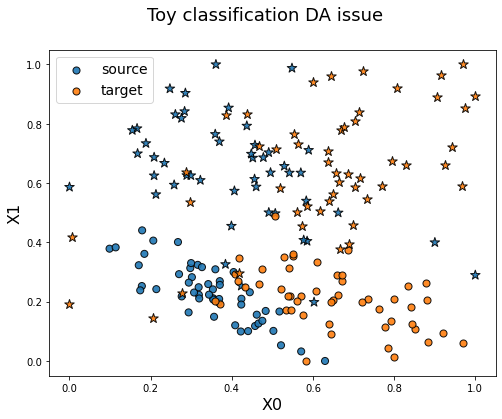

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
show()
plt.show()

Notice that we also define a ``writer`` which will be used to record the evolution of predictions through epochs.

As we can see in the figure above (plotting the two dimensions of the input data),
source and target data define two distinct domains. We have modeled here a classical unsupervised 
DA issue where the goal is to build a good model on orange data knowing only the labels ("o" or "*" given by ``y``) of the blue
points.

We now define the base model used to learn the task. We use here a neural network with two hidden layer.
We also define a ``SavePrediction`` callback in order to save the prediction of the neural network at
each epoch.

In [111]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Reshape
from tensorflow.keras.optimizers import Adam

def get_model(input_shape=(2,)):
    model = Sequential()
    model.add(Dense(100, activation='elu',
                    input_shape=input_shape))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(0.01), loss='binary_crossentropy')
    return model

In [131]:
from tensorflow.keras.callbacks import Callback

class SavePrediction(Callback):  
    """
    Callbacks which stores predicted
    labels in history at each epoch.
    """
    def __init__(self, X_grid_=X_grid, Xt_=Xt):
        self.X_grid = X_grid_
        self.Xt = Xt_
        self.custom_history_grid_ = []
        self.custom_history_ = []
        super().__init__()

    def on_epoch_end(self, batch, logs={}):
        """Applied at the end of each epoch"""
        predictions = self.model.predict_on_batch(self.X_grid).reshape(100, 100)
        self.custom_history_grid_.append(predictions)
        predictions = self.model.predict_on_batch(self.Xt).ravel()
        self.custom_history_.append(predictions)

## Src Only

First, let's fit a network on source data without any adaptation. As we can observe,
the "o" labels from the target domain are missclassified.
Because of the "*" blue points close to the "o" domain, the network learns a class
border not regularized enough and then misclassifies the target "*" data.

In [132]:
np.random.seed(0)
tf.random.set_seed(0)

model = get_model()
save_preds = SavePrediction()
model.fit(Xs, ys, callbacks=[save_preds], epochs=100, batch_size=100, verbose=0);

In [133]:
def animate(i):
    plt.clf()
    yp_grid = (save_preds.custom_history_grid_[i]>0.5).astype(int)
    yp_t = save_preds.custom_history_[i]>0.5
    show(yp_grid, yp_t)

In [351]:
%matplotlib notebook
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
animate(99)
plt.show()

![src_only](../_static/images/srcOnlyCla.gif)

In [108]:
ani = animation.FuncAnimation(fig, animate, frames=100, repeat=False)
ani.save('srcOnlyClassif.mp4', writer=writer)

## mSDA

Let's now consider the domain adaptation method [mSDA](../generated/adapt.feature_based.mSDA.html). 
This "two-stage" method first perfroms a feature encoding on source data and then fits
an estimator using the new feature space.

The encoded features are learned with a stacked denoising autoencoder. Here we choose to reduce
the feature space to one feature with the encoder. 

In [178]:
def get_encoder():
    model = Sequential()
    model.add(Dense(100, activation='elu', input_shape=(2,)))
    model.add(Dense(1, activation=None))
    model.compile(optimizer=Adam(0.01), loss='mse')
    return model

def get_decoder():
    model = Sequential()
    model.add(Dense(100, activation='elu', input_shape=(1,)))
    model.add(Dense(2, activation="sigmoid"))
    model.compile(optimizer=Adam(0.01), loss='mse')
    return model

In [179]:
from adapt.feature_based import mSDA

model = mSDA(get_encoder(), get_decoder(), get_model((1,)),
             noise_lvl=0.1, random_state=0)
model.fit_embeddings(Xs, Xt, epochs=100, batch_size=200, verbose=0);

In [180]:
save_preds = SavePrediction(model.predict_features(X_grid), model.predict_features(Xt))
model.fit_estimator(model.predict_features(Xs), ys, callbacks=[save_preds],
                    epochs=100, batch_size=100, verbose=0);

In [190]:
np.random.seed(0)
noise = np.random.randn(100, 1) * 0.1
noise_grid = np.random.randn(len(X_grid), 1)* 0.1
Xs_enc = model.predict_features(Xs)
Xs_enc = np.concatenate((noise, Xs_enc), 1)
Xt_enc = model.predict_features(Xt)
Xt_enc = np.concatenate((noise, Xt_enc), 1)
X_grid_enc = model.predict_features(X_grid)
X_grid_enc = np.concatenate((noise_grid, X_grid_enc), 1)
x_grid_enc = X_grid_enc[:, 0].reshape(100,100)
y_grid_enc = X_grid_enc[:, 1].reshape(100,100)
    
    
def animate_msda(i):
    yp_grid = (save_preds.custom_history_grid_[i]>0.5).astype(int)
    yp_t = save_preds.custom_history_[i]>0.5
    plt.sca(ax1)
    ax1.clear()
    ax1.set_title("Input Space", fontsize=16)
    show(yp_grid, yp_t)
    plt.sca(ax2)
    ax2.clear()
    ax2.set_title("Encoded Space", fontsize=16)
    show(yp_grid, yp_t,
         x_grid=x_grid_enc, y_grid=y_grid_enc, Xs=Xs_enc, Xt=Xt_enc)
    ax2.set_xlabel("U0", fontsize=16)
    ax2.set_ylabel("U1", fontsize=16)

In [350]:
%matplotlib notebook
fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(16, 6))
animate_msda(99)
plt.show()

![msda](../_static/images/msda.gif)

In [192]:
ani = animation.FuncAnimation(fig, animate_msda, frames=100, repeat=False)
ani.save('mSDAClassif.mp4', writer=writer)

We plot on the left, the evolution of the delimiting line through epochs. On the right
we represent the one dimensional encoded space (on the y axis), we give random x coordinate
to the inputs in order to get a better visualization.

As we can see, on the encoded feature space blue and orange "*" labels go on one side and "o" on 
the other. So when fitting the classifier on the encoded space using blue data, the network learns a
good delimitation line for both domains. Thus [mSDA](../generated/adapt.feature_based.mSDA.html)
perfroms an efficient adaptation between domains for this toy DA issue.

## DANN

We now consider the [DANN](../generated/adapt.feature_based.DANN.html) method.
This method consists in learning a new feature representation on which no 
``discriminator`` network can be able to classify between source and target data.

This is done with adversarial techniques following the principle of GANs.

In [276]:
def get_encoder(input_shape=(2,)):
    model = Sequential()
    model.add(Dense(100, activation='elu',
                    input_shape=input_shape))
    model.add(Dense(2, activation="sigmoid"))
    model.compile(optimizer=Adam(0.01), loss='mse')
    return model

def get_task(input_shape=(2,)):
    model = Sequential()
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(0.01), loss='mse')
    return model

def get_discriminator(input_shape=(2,)):
    model = Sequential()
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=Adam(0.01), loss='mse')
    return model

In [277]:
from tensorflow.keras.callbacks import Callback

class SavePredictionDann(Callback):  
    """
    Callbacks which stores predicted
    labels in history at each epoch.
    """
    def __init__(self, X_grid_=X_grid, Xt_=Xt, Xs_=Xs):
        self.X_grid = X_grid_
        self.Xt = Xt_
        self.Xs = Xs_
        self.custom_history_grid_ = []
        self.custom_history_ = []
        self.custom_history_enc_s = []
        self.custom_history_enc_t = []
        self.custom_history_enc_grid = []
        self.custom_history_disc = []
        super().__init__()

    def on_epoch_end(self, batch, logs={}):
        """Applied at the end of each epoch"""
        predictions = model.task_.predict_on_batch(
            model.encoder_.predict_on_batch(self.X_grid)).reshape(100, 100)
        self.custom_history_grid_.append(predictions)
        predictions = model.task_.predict_on_batch(
            model.encoder_.predict_on_batch(self.Xt)).ravel()
        self.custom_history_.append(predictions)
        predictions = model.encoder_.predict_on_batch(self.Xs)
        self.custom_history_enc_s.append(predictions)
        predictions = model.encoder_.predict_on_batch(self.Xt)
        self.custom_history_enc_t.append(predictions)
        predictions = model.encoder_.predict_on_batch(self.X_grid)
        self.custom_history_enc_grid.append(predictions)
        predictions = model.discriminator_.predict_on_batch(
            model.encoder_.predict_on_batch(self.X_grid)).reshape(100, 100)
        self.custom_history_disc.append(predictions)

In [286]:
from adapt.feature_based import DANN

save_preds = SavePredictionDann()

model = DANN(get_encoder(), get_task(), get_discriminator(),
             lambda_=1.0, optimizer=Adam(0.001), random_state=0)

model.fit(Xs, ys, Xt,
          callbacks=[save_preds],
          epochs=300, batch_size=100, verbose=0);

In [294]:
enc_s = np.concatenate(save_preds.custom_history_enc_s)
enc_t = np.concatenate(save_preds.custom_history_enc_t)
enc = np.concatenate((enc_s, enc_t))
x_min, y_min = enc.min(0)
x_max, y_max = enc.max(0)

x_min, y_min = (0., 0.)
x_max, y_max = (1., 1.)

def animate_dann(i):
    yp_grid = (save_preds.custom_history_grid_[i]>0.5).astype(int)
    yp_t = save_preds.custom_history_[i]>0.5
    plt.sca(ax1)
    ax1.clear()
    ax1.set_title("Input Space", fontsize=16)
    show(yp_grid, yp_t)
    plt.sca(ax2)
    ax2.clear()
    ax2.set_title("Encoded Space", fontsize=16)
    Xs_enc = save_preds.custom_history_enc_s[i]
    Xt_enc = save_preds.custom_history_enc_t[i]
    X_grid_enc = save_preds.custom_history_enc_grid[i]
    x_grid_enc = X_grid_enc[:, 0].reshape(100,100)
    y_grid_enc = X_grid_enc[:, 1].reshape(100,100)
    disc_grid = (save_preds.custom_history_disc[i]>0.5).astype(int)
    show(yp_grid, yp_t,
         x_grid=x_grid_enc, y_grid=y_grid_enc,
         Xs=Xs_enc, Xt=Xt_enc, disc_grid=disc_grid)
    ax2.set_xlabel("U0", fontsize=16)
    ax2.set_ylabel("U1", fontsize=16)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)

In [349]:
%matplotlib notebook
fig, (ax1 , ax2) = plt.subplots(1, 2, figsize=(16, 6))
animate_dann(299)
plt.show()

![dann](../_static/images/dann.gif)

In [300]:
ani = animation.FuncAnimation(fig, animate_dann, frames=300, repeat=False)
ani.save('DANNClassifTrue3.mp4', writer=writer)

As we can see on the figure above, when applying [DANN](../generated/adapt.feature_based.DANN.html)
algorithm, source data are projected on target data in the encoded space. Thus a ``task`` network
trained in parallel to the ``encoder`` and the ``discriminator`` is able to well classify "o" from "*" in the target domain.

## Instance Based

Finally, we consider here the instance-based method [KMM](../generated/adapt.instance_based.KMM.html).
This method consists in reweighting source instances in order to minimize the MMD distance between
source and target domain. Then the algorithm trains a classifier using the reweighted source data.

In [344]:
from adapt.instance_based import KMM

save_preds = SavePrediction()

model = KMM(get_model(), kernel_params=dict(gamma=1), random_state=0)

model.fit(Xs, ys, Xt,
          callbacks=[save_preds],
          epochs=100, batch_size=100, verbose=0);

Fitting weights...
     pcost       dcost       gap    pres   dres
 0:  4.1412e+04 -1.3491e+06  3e+07  4e-01  2e-15
 1:  1.8736e+02 -2.9533e+05  4e+05  2e-03  9e-13
 2:  2.0702e+02 -3.6581e+04  4e+04  2e-05  3e-13
 3:  8.2217e+01 -1.6809e+04  2e+04  7e-06  1e-13
 4: -3.5699e+03 -2.6162e+04  2e+04  7e-06  1e-13
 5: -3.6501e+03 -7.6959e+03  4e+03  1e-06  2e-14
 6: -3.8524e+03 -8.5199e+03  5e+03  3e-16  8e-16
 7: -4.0411e+03 -4.6607e+03  6e+02  2e-16  2e-16
 8: -4.0654e+03 -4.4933e+03  4e+02  2e-16  2e-16
 9: -4.0776e+03 -4.1640e+03  9e+01  2e-16  2e-16
10: -4.0853e+03 -4.1556e+03  7e+01  2e-16  2e-16
11: -4.0894e+03 -4.0973e+03  8e+00  2e-16  2e-16
12: -4.0903e+03 -4.0934e+03  3e+00  1e-16  2e-16
13: -4.0906e+03 -4.0912e+03  6e-01  2e-16  2e-16
14: -4.0906e+03 -4.0911e+03  4e-01  2e-16  2e-16
15: -4.0907e+03 -4.0908e+03  1e-01  2e-16  2e-16
16: -4.0907e+03 -4.0908e+03  5e-02  2e-16  2e-16
17: -4.0908e+03 -4.0908e+03  2e-02  2e-16  2e-16
18: -4.0908e+03 -4.0908e+03  3e-03  2e-16  3e-16
Op

In [345]:
def animate_kmm(i):
    plt.clf()
    yp_grid = (save_preds.custom_history_grid_[i]>0.5).astype(int)
    yp_t = save_preds.custom_history_[i]>0.5
    weights_src = model.predict_weights().ravel() * 50
    show(yp_grid, yp_t, weights_src=weights_src)

In [348]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
animate_kmm(99)
plt.show()

![kmm](../_static/images/kmm.gif)

In [347]:
ani = animation.FuncAnimation(fig, animate_kmm, frames=100, repeat=False)
ani.save('kmmClassif.mp4', writer=writer)

## See also

- [Toy Regression](Regression)
- [Two Moons](Two_moons)